In [22]:
from sklearn import decomposition
import math
from math import sqrt
import pandas as pd
from sklearn.cluster import KMeans
# own modules
from read_pdf import *
from cli import *
from pdf_matrix import *
from query_documents_tfidf import *
from universal_sent_encoder_tensorFlow import *
from hugging_face_sentence_transformer import *

image_src_path = '/Users/klara/Documents/Uni/bachelorarbeit/images/images/*.png'
IMG_SIZE = 600

In [48]:
image_paths = glob.glob(image_src_path)
preprocessed_images = np.array([np.reshape(a=
                                    cv2.normalize(
    cv2.resize(
        cv2.imread(img, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)), 
        None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        , newshape=IMG_SIZE**2) 
        for img in image_paths])


In [4]:

# center the images, cf. https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py
# Global centering (focus on one feature, centering all samples)
preprocessed_images_centered = preprocessed_images - np.mean(preprocessed_images, axis=0)
# Local centering (focus on one sample, centering all features)
preprocessed_images_centered -= preprocessed_images_centered.mean(axis=1).reshape(len(preprocessed_images_centered), -1)

shape of all data:  (2157, 360000)


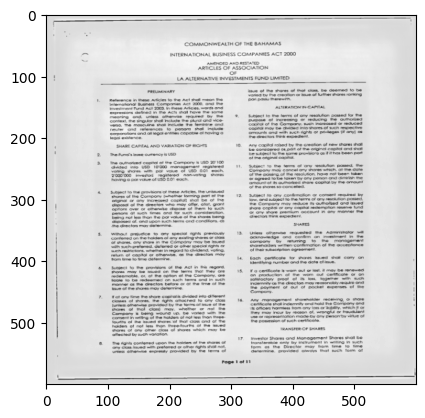

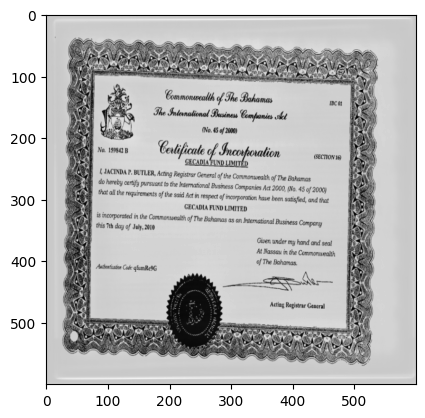

In [5]:

print('shape of all data: ', preprocessed_images_centered.shape)    # (n_samples, n_features)
for img in preprocessed_images_centered[:2]:
    plt.imshow(img.reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.show()

In [6]:
# PCA needs more samples than features, cf. https://stackoverflow.com/questions/51040075/why-sklearn-pca-needs-more-samples-than-new-featuresn-components
# otherwise the number of new faetures will be way smaller than the original number of features
# number of components to keep: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
pca = decomposition.PCA(n_components=0.95, whiten=True)
#print(preprocessed_images[0].shape)
pca_img = pca.fit_transform(preprocessed_images_centered)
print('PCA components: ', pca.components_.shape)    # (n_new_features/ n_components, n_features)
print('PCA return shape: ', pca_img.shape)  # (n_samples, n_new_features/ n_components)
print('PCA image: ', pca_img)

PCA components:  (1596, 360000)
PCA return shape:  (2157, 1596)
PCA image:  [[-0.49457973 -0.9325093  -1.0200889  ...  0.17778437 -0.39769784
  -0.7124197 ]
 [ 2.1588306  -0.31817797 -2.5783694  ...  0.15749459  0.34740514
   0.05203834]
 [-0.06517542  0.62133616  0.92903185 ...  0.5882144   0.268684
  -0.15458353]
 ...
 [-0.4576301  -0.4185414  -0.34017754 ...  0.27956834  0.15305246
   0.45167935]
 [-0.20035341  0.56144863  0.0771568  ... -0.8565204  -0.37124503
   0.8977144 ]
 [-0.62415177 -0.5792656  -0.6230913  ...  0.03740497 -0.09493261
   0.76938975]]


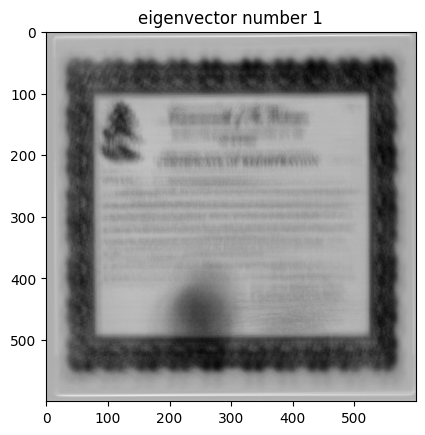

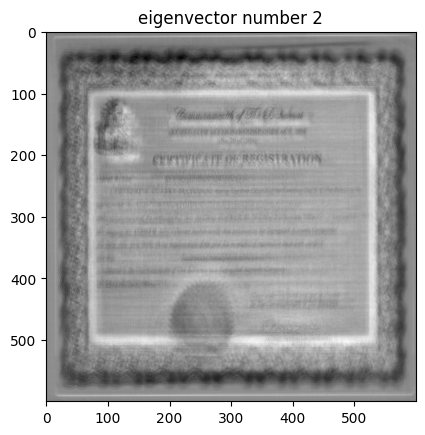

In [47]:
# plot eigenvectors as images
i = 1
for img in pca.components_[:2]:
    plt.imshow(img.reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.title('eigenvector number ' + str(i))
    i += 1
    plt.show()

In [20]:
# save representation of images by linear combination of eigenvectors in dataframe
pca_weights = pd.DataFrame({'path': image_paths, 'pca_weights': 0})
pca_weights.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    pca_weights.loc[[image_paths[i]], 'pca_weights'] = pd.Series([pca_img[i]], index=pca_weights.index[[i]])

pca_weights

,pca_weights
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC56-13.png,"[-0.49457973, -0.9325093, -1.0200889, 0.892540..."
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC80-2.png,"[2.1588306, -0.31817797, -2.5783694, -0.988633..."
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC45-47.png,"[-0.06517542, 0.62133616, 0.92903185, -0.89272..."
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC51-32.png,"[-0.4570901, -0.61139214, -0.3414314, -0.13584..."
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC25-7.png,"[-0.41179225, -0.089439385, 0.240256, 0.601085..."
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC86-15.png,"[-0.472644, -0.6066075, 0.18075386, 0.40924847..."
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC46-9.png,"[-0.39015302, -0.3426129, 0.18383561, 1.086703..."
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC88-10.png,"[-0.4576301, -0.4185414, -0.34017754, 0.881138..."


In [37]:
# identify clusters by similar weights (linear combination) of eigenvectors
NUM_CLASSES = 4
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(pca_weights['pca_weights'].to_list())
pca_weights['cluster'] = kmeans.labels_
display(pca_weights)

,pca_weights,cluster
path,,
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC56-13.png,"[-0.49457973, -0.9325093, -1.0200889, 0.892540...",2
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC80-2.png,"[2.1588306, -0.31817797, -2.5783694, -0.988633...",2
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC45-47.png,"[-0.06517542, 0.62133616, 0.92903185, -0.89272...",2
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC51-32.png,"[-0.4570901, -0.61139214, -0.3414314, -0.13584...",2
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC25-7.png,"[-0.41179225, -0.089439385, 0.240256, 0.601085...",2
...,...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC86-15.png,"[-0.472644, -0.6066075, 0.18075386, 0.40924847...",2
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC46-9.png,"[-0.39015302, -0.3426129, 0.18383561, 1.086703...",2
/Users/klara/Documents/Uni/bachelorarbeit/images/images/SAC88-10.png,"[-0.4576301, -0.4185414, -0.34017754, 0.881138...",2


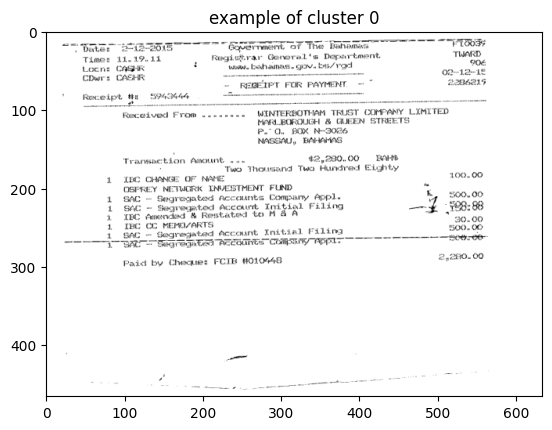

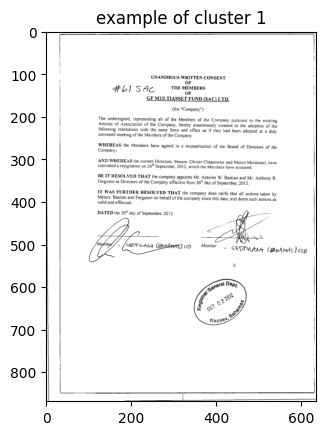

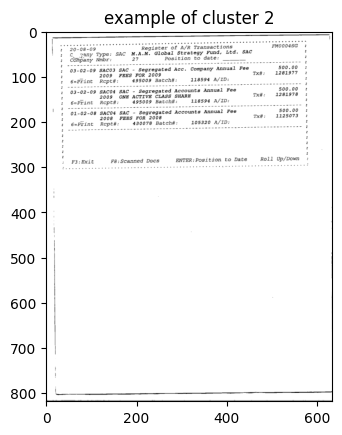

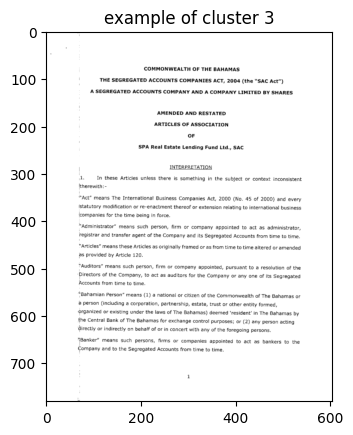

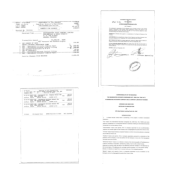

In [41]:
# display sample document per class
example_images = []
for i in range(NUM_CLASSES):
    example_img = pca_weights[pca_weights['cluster'] == i].sample(1).index.values[0]
    example_images.append(example_img)
    plt.imshow(cv2.imread(example_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('example of cluster ' + str(i))
    plt.show()

create_image_matrix(example_images, dim=int(math.sqrt(NUM_CLASSES)), output_path='/Users/klara/Downloads/')

Class distribution:  [2114   41    1    1]


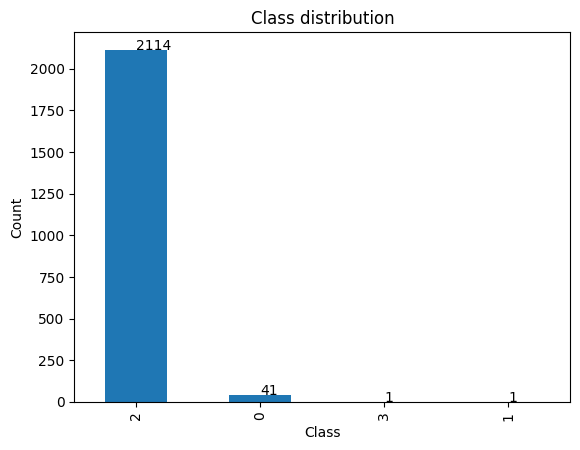

In [46]:
# class/ cluster distribution
pca_weights['cluster'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
cluster_counts = pca_weights['cluster'].value_counts().sort_values(inplace=False, ascending=False).values
# adding labels to bars, c.f. https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
for i in range(len(pca_weights['cluster'].value_counts())):
        plt.text(i,cluster_counts[i], cluster_counts[i])

In [ ]:
# TODO: visualize the compressed data as an image
for img in pca_img[:2]:
    print('Image shape: ', img.shape)
    dim = int(sqrt(len(img)))
    print('Image dim: ', dim)
    plt.imshow(np.reshape(img[:dim**2], dim, dim), cmap='gray')
    plt.show()